# 0. Preamble

Import dependencies, and set some notebook-wide definitions and parameters

## Import dependencies

In [3]:

import numpy as np
from lmfit import minimize, Parameters
from arviz import hdi

from matplotlib import patheffects, rcParams, ticker, gridspec, pyplot as plt

from copy import deepcopy
import gc
import gzip
from tqdm import tqdm
import dill
from typing import Union

import gekim as gk
from gekim.utils.helpers import round_sig


## General settings

In [4]:
# Variables for plot styling
points_lw = 0.5
dash_stroke = 2.5
border_lw = 0.8
sample_alpha = 0.2
sample_lw = 0.8

# Set interactive backend
%matplotlib inline

# Set matplotlib parameters for plotting
rcParams.update({
    'font.size': 18,
    'figure.autolayout': False,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'axes.formatter.useoffset': False,
    'axes.formatter.limits': (-4, 5),
    'axes.axisbelow': False,
})

# Custom formatter for mpl tick labels
class CustomSciFormatter(ticker.ScalarFormatter):
    def __init__(self, low=-3, high=4, useMathText=True, sig_figs=3, force_sci=False, useOffset=False, **kwargs):
        super().__init__(useMathText=useMathText, **kwargs)
        self.low = low  # Lower exponent bound
        self.high = high  # Upper exponent bound
        self.sig_figs = sig_figs
        self.force_sci = force_sci
        self.set_useOffset(useOffset)
        
    def __call__(self, x, pos=None):
        if x == 0:
            return '0'
        exponent = int(np.floor(np.log10(abs(x))))
        if self.low <= exponent <= self.high and not self.force_sci:
            return f"{round_sig(x,sig_figs=self.sig_figs,autoformat=False)}"
        else:
            mantissa = x / (10 ** exponent)
            return f"{round_sig(mantissa,sig_figs=self.sig_figs,autoformat=False)}E{exponent:d}"


## General functions

In [5]:

def format_spines(fig: plt.Figure, zorder: float = 1e6, lw=1) -> None:
    """Increases linewidth and zorder of axes spines"""
    for ax in fig.get_axes():
        for spine in ax.spines.values():
            spine.set_zorder(zorder)
            spine.set_linewidth(lw)

def clear_fig(fig: plt.Figure) -> None:
    """Clear and garbage collect a matplotlib figure"""
    for ax in fig.get_axes():
        ax.clear()
    fig.clear()
    gc.collect()
    return

def calc_x_spans(id_map: list, lig_data: dict, tr_data: list, dr_data: list, 
                 span_extra: float = 1.2) -> tuple[np.ndarray, np.ndarray]:
    """Calculate the time and dose xspans based on the exp data"""
    
    time_span = [0, 1e-9]
    dose_span = [np.inf, 0]

    for exp_id, data_type, x_data_idx in id_map:

        if data_type == "tr":
            exp_data = lig_data["time response"][exp_id]
            x_data = tr_data[x_data_idx][0]
            time_span[1] = max(np.max(x_data), time_span[1])
            if "blacklisted" in exp_data:
                time_span[1] = max(np.max(exp_data["blacklisted"]["time"]), time_span[1])

        elif data_type == "dr":
            exp_data = lig_data["dose response"][exp_id]
            x_data = dr_data[x_data_idx][0]
            dose_span[0] = min(np.min(x_data), dose_span[0])
            dose_span[1] = max(np.max(x_data), dose_span[1])
            if "blacklisted" in exp_data:
                dose_span[0] = min(np.min(exp_data["blacklisted"]["concL0"]), dose_span[0])
                dose_span[1] = max(np.max(exp_data["blacklisted"]["concL0"]), dose_span[1])

    time_span[1] *= span_extra
    dose_span[0] /= span_extra
    dose_span[1] *= span_extra

    xtr_sim = np.geomspace(max(time_span[0],1e-10), time_span[1], 200)
    xdr_sim = np.geomspace(dose_span[0], dose_span[1], 100)

    return xtr_sim, xdr_sim

def calc_common_x_spans(output_dict: dict, save_key_whitelist: list = [], 
                        save_key_blacklist: list = []) -> tuple[np.ndarray, np.ndarray]:
    """Get a universal, smooth xarray for time- and dose-responses"""
    time_span = (0, -np.inf)
    dose_span = (np.inf, -np.inf)
    
    for save_key, save_data in output_dict.items():
        if save_key_blacklist and save_key in save_key_blacklist:
            continue
        if save_key_whitelist and save_key not in save_key_whitelist:
            continue
        
        xtr_sim = save_data["xtr"]
        xdr_sim = save_data["xdr"]
        time_span = (0, max(time_span[1], xtr_sim.max()))
        dose_span = (min(dose_span[0], xdr_sim.min()), max(dose_span[1], xdr_sim.max()))
    
    xtr_sim = np.geomspace(max(time_span[0],1e-10), time_span[1], 200)
    xdr_sim = np.geomspace(dose_span[0], dose_span[1], 100)
    
    return xtr_sim, xdr_sim


# 1. Set-up
Initialize dictionaries for data and plotting

## Helper dictionaries

In [6]:
# Set loop order of keys
save_keys = ["XO44","KW60P","KW50P_del","KW50P_sil"]

# Dictionaries for plotting utilities
label_dict = {
    "KW50P_del": r"KW50P (Mod$_{\text{del}}$)",
    "KW50P_sil": r"KW50P (Mod$_{\text{sil}}$)",
    "KW60P": r"KW60P",
    "XO44": r"XO44",
    "Bio Rep 1": "Bio Rep 1",
    "Bio Rep 2": "Bio Rep 2",
    "Bio Rep 3": "Bio Rep 3",
    "Bio Rep 4": "Bio Rep 4",
    "koff": r"$k_{\text{off}}\,(\text{s}^{-1})$",
    "kon": r"$k_{\text{on}}\,(\text{(μMs)}^{-1})$",
    "kinact": r"$k_{\text{inact}}\,(\text{s}^{-1})$",
    "kns": r"$k_{\text{ns}}\,(\text{(μMs)}^{-1})$",
    "Kd": r"$K_{\text{d}}\,(\text{μM})$",
    "kdel": r"$k_{\text{del}}\,(\text{s}^{-1})$",
    "frac_sil": r"${\text{Frac}}_{\text{sil}}$",
    "Ceff": r"$\text{C}_{\text{eff}}\,(\text{(μMs)}^{-1})$",
}

color_dict = {
    "KW50P_del": "#FF4100",
    "KW50P_sil": "#FF0041",
    "KW50P": "red", 
    "KW60P": "#08DE00",
    "XO44": "blue",
    "Bio Rep 1": "tab:olive",
    "Bio Rep 2": "tab:cyan",
    "Bio Rep 3": "tab:purple",
    "Bio Rep 4": "tab:pink",
    "avg": "black",
}

shape_dict = {
    "KW50P": "d", 
    "KW60P": "s",
    "XO44": "o",
    "Bio Rep 1": "s",
    "Bio Rep 2": "^",
    "Bio Rep 3": "D",
    "Bio Rep 4": "o",
    "avg": "o",
}

zorder_dict = {
    "KW50P_del":4000,
    "KW50P_sil": 3000,
    "KW60P": 2000,
    "XO44": 1000,
}

## Data
Input experimental data and conditions. The notebook expects conditions and data to be held in a dictionary exemplified below, so any imported spreadsheets should have the data assigned to the appropriate key-value pair.

In [7]:

concP0 = 0.357 # μM , initial concentration of protein
dr_t = 3600 # s , time of collection for dose-response
tr_d = 10 # μM , dose of ligand for time-response

conc_unit_scalar = 1 # μM: 1 
tr_start_delay = 10/60 # min

exp_dict = {}
exp_dict["KW50P"] = {
    "dose response": {
        "Bio Rep 3": {
            "concL0": np.array([0.0, 0.25, 0.5, 1, 5, 25, 50])*conc_unit_scalar,
            "concP0": concP0*conc_unit_scalar,
            "time": dr_t,
            "raw intden": np.array([13794, 25564, 32904, 56124, 83307, 130035, 166816]),
        },
        "Bio Rep 4": {
            "concL0": np.array([0.0, 0.25, 0.5, 1, 2, 5, 25])*conc_unit_scalar,
            "concP0": concP0*conc_unit_scalar,
            "time": dr_t,
            "raw intden": np.array([31084, 34865, 58213, 134839, 240784, 637147, 833995]),
        },
    },
    "time response": { 
        "Bio Rep 1": {
            "concL0": tr_d*conc_unit_scalar,
            "concP0": concP0*conc_unit_scalar,
            "time": np.array([tr_start_delay, 30, 60, 90, 120, 240, 360])*60, # s
            "raw intden": np.array([314, 19770, 34996, 46251, 37640, 78013, 71737]),
        },
        "Bio Rep 2": {
            "concL0": tr_d*conc_unit_scalar,
            "concP0": concP0*conc_unit_scalar,
            "time": np.array([tr_start_delay, 10, 20, 30, 45, 60, 120, 180, 240, 315, 360, 420])*60, # s
            "raw intden": np.array([996, 6506, 5057, 7092, 14879, 18403, 53529, 58977, 70362, 80395, 74322, 80137]),
        },
    },
}
exp_dict["KW60P"] = {
    "dose response": {
        "Bio Rep 3": {
            "concL0": np.array([0.0, 0.25, 0.5, 1, 5, 25, 50])*conc_unit_scalar,
            "concP0": concP0*conc_unit_scalar,
            "time": dr_t,
            "raw intden": np.array([19607, 43893, 88376, 110231, 138345, 188728, 237110]),
        },
        "Bio Rep 4": {
            "concL0": np.array([0.0, 0.25, 0.5, 1, 2, 5, 25])*conc_unit_scalar,
            "concP0": concP0*conc_unit_scalar,
            "time": dr_t,
            "raw intden": np.array([19201, 82575, 260811, 544654, 660297, 781184, 1258963]),
        },
    },
    "time response": { 
        "Bio Rep 1": {
            "concL0": tr_d*conc_unit_scalar,
            "concP0": concP0*conc_unit_scalar,
            "time": np.array([tr_start_delay, 30, 60, 90, 120, 240, 360])*60, # s
            "raw intden": np.array([3128, 37128, 45621, 73690, 101068, 151836, 201360]),
        },
        "Bio Rep 2": {
            "concL0": tr_d*conc_unit_scalar,
            "concP0": concP0*conc_unit_scalar,
            "time": np.array([tr_start_delay, 10, 20, 30, 45, 60, 120, 180, 240, 315, 360, 420])*60, # s
            "raw intden": np.array([2540, 5890, 11509, 12957, 21333, 25616, 38859, 44814, 58981, 54724, 59367, 56213]),
        },
    },
}
exp_dict["XO44"] = {
    "dose response": {
        "Bio Rep 3": {
            "concL0": np.array([0, 0.05, 0.25, 0.5, 1, 5, 25, 50])*conc_unit_scalar,
            "concP0": concP0*conc_unit_scalar,
            "time": dr_t,
            "raw intden": np.array([0, 1279, 7741, 22091, 81154, 114956, 144788, 182055]),
        },
    },
    "time response": { 
        "Bio Rep 1": {
            "concL0": tr_d*conc_unit_scalar,
            "concP0": concP0*conc_unit_scalar,
            "time": np.array([tr_start_delay, 2, 5, 10, 30, 60])*60, # s
            "raw intden": np.array([43844, 89123, 85598, 83181, 85014, 133376]),
            "blacklist indices": [1,-1],
        },  
    },
}



### Process Data

In [8]:

def zero_array(data: np.ndarray) -> np.ndarray:
    """Subtract the minimum value from the array"""
    return data - np.min(data)

def normalize_array(data: np.ndarray, norm_idx: int = None) -> np.ndarray:
    """Normalize the array to the maximum value (default) or to a specific index value"""
    if norm_idx is not None:
        return data / data[norm_idx]
    return data / np.max(data)

def process_array(data: np.ndarray, zero=True, norm_idx: int = None) -> np.ndarray:
    """
    Process the array by normalizing and optionally zeroing it.
    It will normalize to the max value or, if specified, a value at a specific index.
    """
    if data is None:
        return
    if zero:
        data = zero_array(data)
    data = normalize_array(data, norm_idx)
    return data

for lig_name, lig_data in exp_dict.items():
    
    # Time course: Normalize to final value
    for exp_id, exp_data in lig_data["time response"].items():
        norm_idx = -1
        exp_data["norm response"] = process_array(
            exp_data.get("raw intden"), zero=False, norm_idx=norm_idx
            )

    # Dose response: Zero and normalize to final value
    for exp_id, exp_data in lig_data["dose response"].items():
        norm_idx = -1 
        if len(np.atleast_1d(norm_idx)) == 0:
            print(f"Desired index not found for {lig_name} {exp_id}, "
                  f"defaulting to max value")
            norm_idx = None
        exp_data["norm response"] = process_array(
            exp_data.get("raw intden"), norm_idx=norm_idx
            )


In [9]:
# Fudge concentrations to avoid zero for log plots
fudge = 1e-2
for lig_name, lig_data in exp_dict.items():
    for exp_id, exp_data in lig_data["dose response"].items():
        exp_data["concL0"] += fudge

In [10]:
# Black list any points in "norm response" found in "blacklist indices"

def blacklist_data(x: np.ndarray, y: np.ndarray, blacklist_indices: list
                   ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Blacklist data points from x and y arrays based on indices in blacklist_indices."""
    if x.shape != y.shape:
        raise ValueError("x and y must have the same shape")
    if len(x.shape) > 1:
        raise ValueError("x must be a 1D array")

    # Normalize and sort indices to avoid index shifting
    blacklist_indices = [i if i >= 0 else len(x) + i for i in blacklist_indices]
    blacklist_indices = sorted(blacklist_indices, reverse=True) 

    x = x.copy()
    y = y.copy()
    bl_x = []
    bl_y = []

    for i in blacklist_indices:
        bl_x.insert(0,x[i])
        bl_y.insert(0,y[i])
        x = np.delete(x, i)
        y = np.delete(y, i)

    bl_x = np.array(bl_x)
    bl_y = np.array(bl_y)

    return x, y, bl_x, bl_y

# Automatically
y_key = "norm response"
for lig_name, lig_data in exp_dict.items():
    # Time response
    x_key = "time"
    for exp_id, data in lig_data["time response"].items():
        if "blacklist indices" in data and len(data["blacklist indices"]) > 0:
            x = data[x_key]
            y = data[y_key]
            print(f"Blacklisting {lig_name} {exp_id} ({x_key},{y_key}){data['blacklist indices']}"
                  f"\n\tBefore:\n\t\t{data[x_key]}\n\t\t{data[y_key]}")
            bl_i = data["blacklist indices"]
            data[x_key], data[y_key], bl_x, bl_y = blacklist_data(x, y, bl_i)
            data["blacklist indices"] = []
            data["blacklisted"] = {x_key: bl_x, y_key: bl_y}
            print(f"\n\tAfter:\n\t\t{data[x_key]}\n\t\t{data[y_key]}"
                  f"\n\tBlacklisted:\n\t\t{bl_x}\n\t\t{bl_y}")
            
   # Dose response
    x_key = "concL0"
    for exp_id, data in lig_data["dose response"].items():
        if "blacklist indices" in data and len(data["blacklist indices"]) > 0:
            x = data[x_key]
            y = data[y_key]
            print(f"Blacklisting {lig_name} {exp_id} ({x_key},{y_key}){data['blacklist indices']}"
                  f"\n\tBefore:\n\t\t{data[x_key]}\n\t\t{data[y_key]}")
            bl_i = data["blacklist indices"]
            data[x_key], data[y_key], bl_x, bl_y = blacklist_data(x, y, bl_i)
            data["blacklist indices"] = []
            data["blacklisted"] = {x_key: bl_x, y_key: bl_y}
            print(f"\n\tAfter:\n\t\t{data[x_key]}\n\t\t{data[y_key]}"
                  f"\n\tBlacklisted:\n\t\t{bl_x}\n\t\t{bl_y}")
                  


Blacklisting XO44 Bio Rep 1 (time,norm response)[1, -1]
	Before:
		[  10.  120.  300.  600. 1800. 3600.]
		[0.32872481 0.66820867 0.64177963 0.62365793 0.63740103 1.        ]

	After:
		[  10.  300.  600. 1800.]
		[0.32872481 0.64177963 0.62365793 0.63740103]
	Blacklisted:
		[ 120. 3600.]
		[0.66820867 1.        ]


# 2. Fit simulations to assays
The goal of this section is to find parameters that produce simulated time- and dose-response curves close to the experimental curves. This is where the kinetic model and parameters are defined.

This notebook should be treated like a guideline. The kinetic scheme and parameters will depend on the system and available data. The initial guesses and fitting method, e.g. least-squares (LS), can make a big difference on where it will minimize. Global minimization methods, e.g. basin-hopping, may suit your needs better.

Note that the minimized values of parameters could vary slightly between machines, but it should remain within the standard error.

## Functions

In [12]:

def make_system(kon, koff, kinact, kns, concL0: Union[float, np.ndarray], 
                concP0: Union[float, np.ndarray], ns_coeff: float = 1, kdel: float = 0, 
                frac_sil: float = 0, quiet=True) -> gk.System:
    """Configure the kinetic scheme. This must be modified to reflect a custom kinetic scheme."""
    scheme = {
        "transitions": {
            "kon": {"k": kon, "source": ["P", "L"], "target": ["P_L"]},
            "koff": {"k": koff, "source": ["P_L"], "target": ["P", "L"]},
            "kinact": {"k": kinact, "source": ["P_L"], "target": ["PL"]}, #irrev step
            "kns": {"k": kns, "source": ["P_ns", "L"], "target": [f"{ns_coeff}P_ns", "P_nsL"]},
            "kdel": {"k": kdel, "source": ["L"], "target": ["0L"]},
            "kon_sil": {"k": kon, "source": ["P", "L_sil"], "target": ["P_L_sil"]},
            "koff_sil": {"k": koff, "source": ["P_L_sil"], "target": ["P", "L_sil"]},
            "kinact_sil": {"k": kinact, "source": ["P_L_sil"], "target": ["PL_sil"]}, #irrev step
            "kns_sil": {"k": kns, "source": ["P_ns", "L_sil"], "target": [f"{ns_coeff}P_ns", "P_nsL_sil"]},
        },
        "species": {
            "L": {"y0": concL0*(1-frac_sil), "label": r"L"},
            "P": {"y0": concP0, "label": r"P"},
            "P_L": {"y0": 0, "label": r"P${\cdot}$L"},
            "PL": {"y0": 0, "label": r"P$-$L"},
            "P_ns": {"y0": concP0, "label": r"P$_{\text{ns}}$"},
            "P_nsL": {"y0": 0, "label": r"P$_{\text{ns}}-$L"},
            "L_sil": {"y0": concL0*frac_sil, "label": r"L$_{\text{sil}}$"},
            "P_L_sil": {"y0": 0, "label": r"P${\cdot}$L$_{\text{sil}}$"},
            "PL_sil": {"y0": 0, "label": r"P$-$L$_{\text{sil}}$"},
            "P_nsL_sil": {"y0": 0, "label": r"P$_{\text{ns}}-$L$_{\text{sil}}$"},
        },
    }
    system = gk.System(scheme, quiet=quiet)
    return system

def simulate_tr(t_eval: np.ndarray, kon, koff, kinact, kns, 
                ns_coeff=1, kdel=0, frac_sil=0, tr_d=10, concP0=0.357, 
                response_sp=["PL","P_nsL"], atol=1e-8, rtol=1e-3) -> np.ndarray:
    """Simulate a time-response curve. 
    The parameters of this function might need to be changed to reflect a custom kinetic scheme."""
    system = make_system(kon,koff,kinact,kns,concL0=tr_d,concP0=concP0,ns_coeff=ns_coeff,
                         kdel=kdel,frac_sil=frac_sil)
    system.simulator = gk.simulators.ODESolver(system)
    system.simulator.simulate(t_eval = t_eval, method="LSODA", atol=atol, rtol=rtol)
    return system.sum_species_simout(whitelist=response_sp) / concP0, system

def simulate_dr(concL0: np.ndarray, kon, koff, kinact, kns, 
                ns_coeff=1, kdel=0, frac_sil=0, concP0=0.357, dr_t=3600, 
                response_sp=["PL", "P_nsL"], atol=1e-8, rtol=1e-3) -> np.ndarray:
    """Simulate a dose-response curve. 
    The parameters of this function might need to be changed to reflect a custom kinetic scheme."""
    system = make_system(kon, koff, kinact, kns, concL0=concL0, concP0=concP0, ns_coeff=ns_coeff,
                         kdel=kdel,frac_sil=frac_sil)
    system.simulator = gk.simulators.ODESolver(system)
    system.simulator.simulate(t_span=(0,dr_t),method="LSODA", atol=atol, rtol=rtol)
    return np.array(
        [simout[-1] for simout in system.sum_species_simout(whitelist=response_sp)]
        ) / concP0, system

def sim_response(params: Parameters, concP0: float, 
                 response_sp: list, tr_data: list = None, dr_data: list = None, 
                 atol: float = 1e-8, rtol: float = 1e-3) -> np.ndarray:
    """
    Simulate time- and dose-response curves for a set of parameters and experiments.
    """
    
    ntr = len(tr_data) if tr_data is not None else 0
    ndr = len(dr_data) if dr_data is not None else 0

    # Unpack parameters
    kon = params['kon'].value
    koff = params['koff'].value
    kinact = params['kinact'].value
    kns = params['kns'].value
    ns_coeff = params['ns_coeff'].value
    kdel = params['kdel'].value
    frac_sil = params['frac_sil'].value
    tr_scalars = np.array([params[f'tr_scalar{i}'].value for i in range(ntr)])
    dr_scalars = np.array([params[f'dr_scalar{i}'].value for i in range(ndr)])

    # Initialize system
    system = make_system(
        kon, koff, kinact, kns, 1, concP0,
        ns_coeff=ns_coeff, kdel=kdel, frac_sil=frac_sil
    )
    system.simulator = gk.simulators.ODESolver(system)

    # Time-response
    response_time_sim = [None] * ntr
    if tr_data is not None:
        ## Collect unique conditions and unique corresponding x-values
        tr_concL0_dict = {}
        for tr_timepoints, tr_concL0 in tr_data:
            if tr_concL0 not in tr_concL0_dict:
                tr_concL0_dict[tr_concL0] = set(tr_timepoints)
            else:
                tr_concL0_dict[tr_concL0].update(tr_timepoints)

        ## Simulate
        tr_sim_results = {}
        for concL0, timepoints in tr_concL0_dict.items():
            timepoints = np.sort(list(timepoints))
            system.species["L"].y0 = concL0 * (1 - frac_sil)
            system.species["L_sil"].y0 = concL0 * frac_sil
            system.simulator.simulate(t_span=(0, np.max(timepoints)*1.2), method="LSODA", 
                                    atol=atol, rtol=rtol, dense_output=True)
            response = system.simout['soln_continuous'](timepoints)
            response = np.sum(np.array(
                [response[system.species[sp].index] for sp in response_sp]
                ), axis=0)
            response /= concP0
            tr_sim_results[concL0] = {
                'timepoints': timepoints,
                'response': response
            }

        ## Match outputs
        for i, (tr_timepoints, tr_concL0) in enumerate(tr_data):
            sim_data = tr_sim_results[tr_concL0]
            indices = np.isin(sim_data['timepoints'], tr_timepoints)
            response = sim_data['response'][indices]
            response_time_sim[i] = response * tr_scalars[i]

    # Dose-response
    response_dose_sim = [None] * ndr
    if dr_data is not None:
        ## Collect unique conditions and unique corresponding x-values
        dr_time_dict = {}
        for dr_doses, dr_time in dr_data:
            if dr_time not in dr_time_dict:
                dr_time_dict[dr_time] = set(dr_doses)
            else:
                dr_time_dict[dr_time].update(dr_doses)

        ## Simulate
        dr_sim_results = {}
        for dr_time, doses in dr_time_dict.items():
            doses = np.array(sorted(doses))
            system.species["L"].y0 = doses * (1 - frac_sil)
            system.species["L_sil"].y0 = doses * frac_sil
            system.simulator.simulate(t_span=(0, dr_time), method="LSODA", atol=atol, rtol=rtol)
            response = system.sum_species_simout(whitelist=response_sp)
            response = np.array([resp[-1] for resp in response])
            response /= concP0
            dr_sim_results[dr_time] = {
                'doses': doses,
                'response': response
            }

        ## Match outputs
        for i, (dr_doses, dr_time) in enumerate(dr_data):
            sim_data = dr_sim_results[dr_time]
            indices = np.isin(sim_data['doses'], dr_doses)
            response = sim_data['response'][indices]
            response_dose_sim[i] = response * dr_scalars[i]

    # Combine outputs
    features_response = np.concatenate(response_time_sim + response_dose_sim)
    features_response[features_response < 0] = 0
    return features_response

def calc_residuals(params: Parameters, tr_data: list, dr_data: list, y_data: list, 
                   response_sp: list, tr_weight: float = 1, dr_weight: float = 1, 
                   weights: np.ndarray = None) -> np.ndarray:
    """Objective function for fitting"""
    
    ntime = sum(len(tr[0]) for tr in tr_data)
    ntr = len(tr_data) if tr_data is not None else 0
    ndr = len(dr_data) if dr_data is not None else 0
    
    y_model = sim_response(params, y_data[0][1], response_sp, tr_data, dr_data)
    
    y_tr = np.concatenate([y[0] for y in y_data[:ntr]]) if ntr > 0 else []
    y_dr = np.concatenate([y[0] for y in y_data[ntr:]]) if ndr > 0 else []
    
    residuals_tr = (y_model[:ntime] - y_tr) * tr_weight
    residuals_dr = (y_model[ntime:] - y_dr) * dr_weight
    
    residuals = (np.concatenate([residuals_tr, residuals_dr])) 

    if weights is not None:
        residuals *= weights
    return residuals


## Set-up 
Define initial guesses and inter-ligand scaling factors

In [13]:
# Guesses
kon_KW = 1.82/conc_unit_scalar # 1/μM 1/s
koff_KW = 3.41e-1 # /s
kinact_KW60P = 2.4e-4 # /s
kon_XO44 = 2.9e3*1e-6 /conc_unit_scalar #1/μM 1/s
koff_XO44 = 8.95e-2 # /s 
kinact_XO44 = .212 # /s 

guesses_dict = {
    "KW50P": {
        "Kd": {"value": 1e-1*conc_unit_scalar, 
               "min": 1.53e-6*conc_unit_scalar, "max": 1e3*conc_unit_scalar},
        "kon": {"value":kon_KW/100, 
                "min": 2.35e-7/conc_unit_scalar, "max": 1.27e3/conc_unit_scalar},
        "koff": {"value":koff_KW/100, "min": 2.75e-7, "max": 1.63e0},
        "kinact": {"value":kinact_KW60P, "min": 1e-5, "max": 1},
        "kns": {"min": 1e-10, "max": 5e-6},
        "tr_scalar": {},
        "dr_scalar": {},
        "kdel": {"vary": False, "value": 0},
        "frac_sil": {"vary": False, "value": 0},
    },
    "KW60P": {
        "Kd": {"value": 1e-1*conc_unit_scalar, 
               "min": 1.53e-6*conc_unit_scalar, "max": 1e3*conc_unit_scalar},
        "kon": {"value":kon_KW/100, 
                "min": 2.35e-7/conc_unit_scalar, "max": 1.27e3/conc_unit_scalar},
        "koff": {"value":koff_KW/100, "min": 2.75e-7, "max": 1.63e0},
        "kinact": {"value":kinact_KW60P, "min": 1e-5, "max": 1},
        "kns": {"min": 1e-10, "max": 5e-6},
        "tr_scalar": {},
        "dr_scalar": {},
        "kdel": {"vary": False, "value": 0},
        "frac_sil": {"vary": False, "value": 0},
    },
    "XO44": {
        "Kd": {"value": 1e-1*conc_unit_scalar, 
               "min": 1.53e-6*conc_unit_scalar, "max": 1e4*conc_unit_scalar},
        "kon": {"value":kon_XO44, 
                "min": 2.35e-7/conc_unit_scalar, "max": 1.27e3/conc_unit_scalar, "vary": True},
        "koff": {"value":koff_XO44, "min": 2.75e-7, "max": 1.63e0, "vary": False},
        "kinact": {"value":kinact_XO44, "min": 1e-5, "max": 10},
        "kns": {"value":5e-6, "min": 1e-10, "max": 3e-5},
        "tr_scalar": {"value": 0.7},
        "dr_scalar": {},
        "kdel": {"vary": False, "value": 0},
        "frac_sil": {"vary": False, "value": 0},
    },
}

guesses_dict["KW50P_del"] = deepcopy(guesses_dict["KW50P"])
guesses_dict["KW50P_del"]["kdel"] = {"vary": True, "value": 1e-3}

guesses_dict["KW50P_sil"] = deepcopy(guesses_dict["KW50P"])
guesses_dict["KW50P_sil"]["frac_sil"] = {"vary": True, "value": 0.5}

weight_dict = {
    "KW50P": {"tr": 1, "dr": 1},
    "KW60P": {"tr": 1, "dr": 1},
    "XO44": {"tr": 0.75, "dr": 1},
}



In [14]:
# Get relative scalings 
# Using last value of each dataset
interligand_scaling = {}

# Time responses
for exp_id in ["Bio Rep 1"]:
    scaling_factor = np.array(
        exp_dict["KW50P"]["time response"][exp_id]["raw intden"] / 
        exp_dict["KW60P"]["time response"][exp_id]["raw intden"]
    )[-1]
    print(f"{exp_id} scaling factor for KW50P to KW60P: {np.round(1/scaling_factor,4)}")
    interligand_scaling[exp_id] = {
        "KW50P": 1/scaling_factor, 
        }

# Dose responses  
for exp_id in ["Bio Rep 3", "Bio Rep 4"]:
    scaling_factor = np.array(
        exp_dict["KW50P"]["dose response"][exp_id]["raw intden"] / 
        exp_dict["KW60P"]["dose response"][exp_id]["raw intden"]
    )[-1]
    print(f"{exp_id} scaling factor for KW50P to KW60P: {np.round(1/scaling_factor,4)}")
    interligand_scaling[exp_id] = {
        "KW50P": 1/scaling_factor, 
        }


Bio Rep 1 scaling factor for KW50P to KW60P: 2.8069
Bio Rep 3 scaling factor for KW50P to KW60P: 1.4214
Bio Rep 4 scaling factor for KW50P to KW60P: 1.5096


## Do fit
For KW60P, XO44, and both KW50P variants, do the fitting algorithm and plot the best fit.

Note that KW50P scaling is dependent on KW60P's best fit, so KW60P must come first in the loop. 

The covalent binding that occurs in the binding pocket (i.e. specific binding) is abbreviated as CO for Covalent Occupancy and plotted as a dashed line. The total covalent binding includes non-specific (ns) binding, and it is plotted as a solid line.

### User-defined variables

In [15]:
CO_spname = "PL" # This is the species that represents covalent occupancy (i.e. specific binding)
response_sp=[CO_spname,"P_nsL"] # The sum of the concentrations of these species will be plotted as the response

save_key_blacklist = []
save_key_whitelist = []

tr_blacklist = []
tr_whitelist = []
dr_blacklist = []
dr_whitelist = []


### Fit Params

In [ ]:

if 'output_dict' not in globals():
    output_dict = {}
    
for save_key in save_keys:
    if save_key_blacklist and save_key in save_key_blacklist:continue
    if save_key_whitelist and save_key not in save_key_whitelist:continue
    lig_name = save_key.split("_")[0]
    lig_data = exp_dict[lig_name]

    print(f"\n{'='*80}\n"
          f"{save_key}\n")
    
    # Get experimental data
    tr_data, dr_data, y_data, id_map = [], [], [], []
    j = 0
    for i, (tr_id, data) in  enumerate(lig_data["time response"].items()):
        if tr_blacklist and tr_id in tr_blacklist:continue
        if tr_whitelist and tr_id not in tr_whitelist:continue
        tr_data.append((data["time"], data["concL0"]))
        y_data.append((data["norm response"], data["concP0"]))
        id_map.append((tr_id,"tr",j))
        j += 1 # only increment j if we're adding data. i increments regardless
    j = 0
    for i, (dr_id, data) in enumerate(lig_data["dose response"].items()):
        if dr_blacklist and dr_id in dr_blacklist:continue
        if dr_whitelist and dr_id not in dr_whitelist:continue
        dr_data.append((data["concL0"], data["time"]))
        y_data.append((data["norm response"], data["concP0"]))
        id_map.append((dr_id,"dr",j))
        j += 1

    # Get guesses
    gd = guesses_dict[save_key]
    Kd_guess = gd["Kd"].get("value",1*conc_unit_scalar)
    kon_guess = gd["kon"].get("value",kon_KW)
    koff_guess = gd["koff"].get("value",koff_KW)
    kinact_guess = gd["kinact"].get("value",kinact_KW60P)
    kns_guess = gd["kns"].get("value",1e-7)
    ns_coeff_guess = gd.get("ns_coeff",{}).get("value",1)
    kdel_guess = gd.get("kdel",{}).get("value",0)
    frac_sil_guess = gd.get("frac_sil",{}).get("value",0)

    # Set up parameters
    params = Parameters()
    params.add('kon', value=kon_guess, 
               min=gd["kon"].get("min",kon_guess/1e5), 
               max=gd["kon"].get("max",kon_guess*1e4), 
               vary=gd["kon"].get("vary",False))
    params.add('koff', value=koff_guess, 
               min=gd["koff"].get("min",koff_guess/1e5), 
               max=gd["koff"].get("max",koff_guess*1e4), 
               vary=gd["koff"].get("vary",True))
    params.add('kinact', value=kinact_guess, 
               min=gd["kinact"].get("min",kinact_guess/1e4), 
               max=gd["kinact"].get("max",kinact_guess*1e4), 
               vary=gd["kinact"].get("vary",True))
    params.add('kns', value=kns_guess, 
               min=gd["kns"].get("min",1e-10/conc_unit_scalar), 
               max=gd["kns"].get("max",4e-5/conc_unit_scalar), 
               vary=gd["kns"].get("vary",True))
    params.add('Kd', value=Kd_guess, 
               min=gd["Kd"].get("min",1.53e-6*conc_unit_scalar), 
               max=gd["Kd"].get("max",1e4*conc_unit_scalar), 
               vary=gd["Kd"].get("vary",False),expr='koff/kon')
    
    ## Add normalization factors
    for exp_id, data_type, x_data_idx in id_map:
        param_str = f"{data_type}_scalar{x_data_idx}"
        scalar_guess = gd[f"{data_type}_scalar"].get("value",0.8)
        if exp_id in interligand_scaling.keys() \
            and lig_name in interligand_scaling[exp_id].keys():
                
            # use KW60P as a base scale
            if "KW60P" not in output_dict.keys():
                print("KW60P not yet fit. Cant use as base scale for interligand scaling.")
                continue
            kw60p_fit = output_dict["KW60P"]["fit_trdr"]
            for i2, (exp_id2, data_type2, x_data_idx2) in enumerate(
                kw60p_fit["id_map"]
                ):
                if exp_id == exp_id2:
                    base_param_str = f"{data_type2}_scalar{x_data_idx2}"
                    base_scale = kw60p_fit["result"].params[base_param_str].value
                    base_scale_uncertainty = kw60p_fit["result"].params[base_param_str].stderr
                    break
            scaled = base_scale * interligand_scaling[exp_id][lig_name]
            scaled_uncertainty = base_scale_uncertainty * interligand_scaling[exp_id][lig_name]
            scaled_lower = max(scaled-2*scaled_uncertainty, 0)
            scaled_upper = scaled+2*scaled_uncertainty
            params.add(param_str, value=scaled, min=scaled_lower, max=scaled_upper, vary=True)
        else:
            params.add(param_str, value=scalar_guess, 
                       min=gd[f"{data_type}_scalar"].get("min",0.08), 
                       max=gd[f"{data_type}_scalar"].get("max",6), 
                       vary=gd[f"{data_type}_scalar"].get("vary",True))

    ## Add nonstandard parameters
    params.add('ns_coeff', value=ns_coeff_guess, 
               min=gd.get("ns_coeff",{}).get("min",1e-4), 
               max=gd.get("ns_coeff",{}).get("max",1), 
               vary=gd.get("ns_coeff",{}).get("vary",False))
    params.add('kdel', value=kdel_guess, 
               min=gd.get("kdel",{}).get("min",0), 
               max=gd.get("kdel",{}).get("max",1e4), 
               vary=gd.get("kdel",{}).get("vary",False))
    params.add('frac_sil', value=frac_sil_guess, 
               min=gd.get("frac_sil",{}).get("min",0), 
               max=gd.get("frac_sil",{}).get("max",0.9), 
               vary=gd.get("frac_sil",{}).get("vary",False))

    # Weights 
    tr_wgt, dr_wgt = weight_dict[lig_name].get("tr",1),weight_dict[lig_name].get("dr",1)

    ## Minimize params with LS fitting
        # basin_hopping is also good bc it can escape the regime of the intial guess
    fit_kws = {"ftol":1e-8, "xtol":None, "gtol":None, "verbose":0}
    system = make_system(kon_KW, koff_KW, kinact_KW60P, 1e-7, tr_d, concP0, 
                         ns_coeff=1, kdel=0, frac_sil=0)
    fit_result = minimize(calc_residuals, params, args=(tr_data, dr_data, y_data, response_sp), 
                          kws={"tr_weight":tr_wgt, "dr_weight":dr_wgt},
                          method='least_squares', **fit_kws) 
    fit_result.params.pretty_print(); print("\n")

    # Save output to dictionary
    output_dict[save_key] = {
        "lig_name": lig_name,
        "fit_trdr": {
            "result": fit_result,
            "tr_data": tr_data,
            "dr_data": dr_data,
            "y_data": y_data,
            "id_map": id_map,
            "y_data_scaled": {},
            "system": system
        }
    }
    
    ## Save scaled exp y data 
    for i, (exp_id, data_type, x_data_idx) in enumerate(id_map):
        scalar_name = f"{data_type}_scalar{x_data_idx}"
        scalar_value = fit_result.params[scalar_name].value
        y_data_scaled = y_data[i][0] / scalar_value
        output_dict[save_key]["fit_trdr"]["y_data_scaled"][exp_id] = y_data_scaled
        print(f"{exp_id} scalar name: {scalar_name}")

    ## Save span of data for plotting
    xtr_sim, xdr_sim = calc_x_spans(id_map, lig_data, tr_data, dr_data)
    output_dict[save_key]["xtr"] = xtr_sim
    output_dict[save_key]["xdr"] = xdr_sim



XO44

Name           Value      Min      Max   Stderr     Vary     Expr Brute_Step
Kd             40.09 1.53e-06    1e+04    52.68    False koff/kon     None
dr_scalar0    0.5326     0.08        6   0.1636     True     None     None
frac_sil           0        0      0.9        0    False     None     None
kdel               0        0    1e+04        0    False     None     None
kinact       0.02196    1e-05       10  0.01531     True     None     None
kns         5.152e-06    1e-10    3e-05 6.316e-06     True     None     None
koff          0.0895 2.75e-07     1.63        0    False     None     None
kon         0.002232 2.35e-07     1270 0.002933     True     None     None
ns_coeff           1   0.0001        1        0    False     None     None
tr_scalar0    0.5927     0.08        6   0.1464     True     None     None


Bio Rep 1 scalar name: tr_scalar0
Bio Rep 3 scalar name: dr_scalar0

KW60P

Name           Value      Min      Max   Stderr     Vary     Expr Brute_Step
Kd       

### Sim and Plot

Run a kinetic simulation using the best-fit parameters and plot the normalized specific and non-specific binding response.


XO44


KW60P


KW50P_del


KW50P_sil



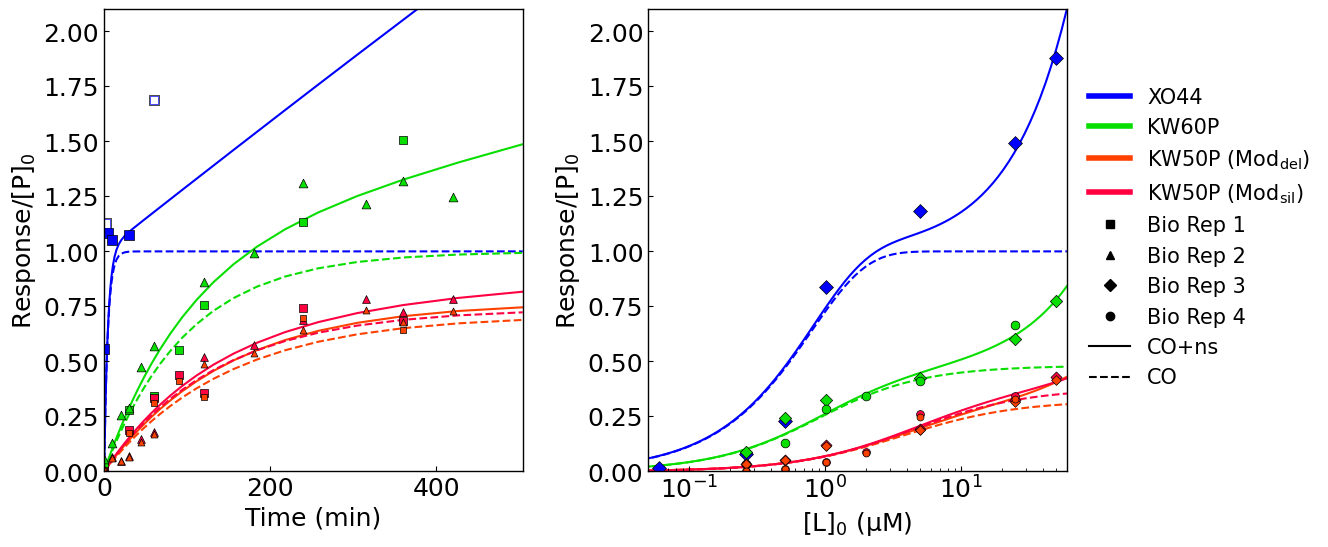

In [17]:

# Initialize figure and x-ranges
fig, axs = plt.subplots(1,2,figsize=(14, 6), gridspec_kw={'wspace': 0.3})
format_spines(fig)

xtr_sim, xdr_sim = calc_common_x_spans(output_dict, save_key_whitelist, save_key_blacklist)

id_set = set()
for save_key, save_data in output_dict.items():
    if save_key_blacklist and save_key in save_key_blacklist:continue
    if save_key_whitelist and save_key not in save_key_whitelist:continue
    print(f"\n{'='*80}\n"
          f"{save_key}\n")
    
    lig_name = save_data["lig_name"]
    fit_trdr = save_data["fit_trdr"]
    tr_data = save_data["fit_trdr"]["tr_data"]
    dr_data = save_data["fit_trdr"]["dr_data"]
    fit_result = save_data["fit_trdr"]["result"]
    
    # Plot experimental data
    base_scatter_size = 75
    scatter_size = base_scatter_size - 25*np.sqrt(zorder_dict[save_key]/1000)
    for exp_id, data_type, x_data_idx in fit_trdr["id_map"]:
        id_set.add(exp_id)
        y_data_scaled = fit_trdr["y_data_scaled"][exp_id]
        scalar_name = f"{data_type}_scalar{x_data_idx}"
        scalar_value = fit_trdr["result"].params[scalar_name].value
        if data_type == "tr":
            exp_data = exp_dict[lig_name]["time response"][exp_id]
            x_data = tr_data[x_data_idx][0]
            axs[0].scatter(x_data/60, y_data_scaled, label=None, c=color_dict[save_key], 
                           marker=shape_dict[exp_id], ls='None',alpha=1, ec="black", 
                           lw=points_lw, zorder=zorder_dict[save_key]+110+1e5,s=scatter_size)
            if "blacklisted" in exp_data:
                axs[0].scatter(exp_data["blacklisted"]["time"]/60, 
                               exp_data["blacklisted"]["norm response"] / scalar_value,
                               label=None, marker=shape_dict[exp_id], 
                               ls='None', fc="none",zorder=zorder_dict[save_key]+110+1e5,
                               ec="black", lw=points_lw,s=scatter_size)
                axs[0].scatter(exp_data["blacklisted"]["time"]/60, 
                               exp_data["blacklisted"]["norm response"] / scalar_value, 
                               label=None, marker=shape_dict[exp_id], 
                               ls='None', fc="none", zorder=zorder_dict[save_key]+110+1e5,
                               ec=color_dict[save_key], lw=points_lw,s=scatter_size*0.75)
        elif data_type == "dr":
            exp_data = exp_dict[lig_name]["dose response"][exp_id]
            x_data = dr_data[x_data_idx][0]
            axs[1].scatter(x_data, y_data_scaled, label=None, c=color_dict[save_key], 
                           marker=shape_dict[exp_id], ls='None',alpha=1, ec="black", 
                           lw=points_lw, zorder=zorder_dict[save_key]+110+1e5,s=scatter_size)
            if "blacklisted" in exp_data:
                axs[1].scatter(exp_data["blacklisted"]["concL0"], 
                               exp_data["blacklisted"]["norm response"] / scalar_value, 
                               label=None, marker=shape_dict[exp_id], 
                               ls='None', fc="none", zorder=zorder_dict[save_key]+110+1e5,
                               ec="black", lw=points_lw,s=scatter_size)
                axs[1].scatter(exp_data["blacklisted"]["concL0"], 
                               exp_data["blacklisted"]["norm response"] / scalar_value, 
                               label=None, marker=shape_dict[exp_id], 
                               ls='None', fc="none", zorder=zorder_dict[save_key]+110+1e5,
                               ec=color_dict[save_key], lw=points_lw,s=scatter_size*0.75)

    # Time-response
    ## Sim with best-fit params  
    tr_system = make_system(fit_result.params["kon"].value,fit_result.params["koff"].value,
                            fit_result.params["kinact"].value,fit_result.params["kns"].value,
                            tr_d,concP0,ns_coeff=fit_result.params["ns_coeff"].value,
                            kdel=fit_result.params["kdel"].value, 
                            frac_sil=fit_result.params["frac_sil"].value,quiet=True)
    tr_system.simulator = gk.simulators.ODESolver(tr_system)
    tr_system.simulator.simulate(t_eval=xtr_sim,method="LSODA")
    ytr_sim = tr_system.sum_species_simout(whitelist=response_sp) / concP0 # normalize to total P
    ytr_sim_CO = tr_system.sum_species_simout(whitelist=[CO_spname]) / concP0
    output_dict[save_key]["fit_trdr"]["tr_system"] = tr_system
    
    ## Plot sim 
    axs[0].plot(xtr_sim/60, ytr_sim, label=None, c=color_dict[save_key], ls='-')
    axs[0].plot(xtr_sim/60, ytr_sim_CO, label=None, c=color_dict[save_key], ls='--')

    # Dose-response
    ## Sim with best-fit params
    dr_system = make_system(fit_result.params["kon"].value,fit_result.params["koff"].value,
                            fit_result.params["kinact"].value,fit_result.params["kns"].value,
                            xdr_sim,concP0,ns_coeff=fit_result.params["ns_coeff"].value,
                            kdel=fit_result.params["kdel"].value, 
                            frac_sil=fit_result.params["frac_sil"].value)
    dr_system.simulator = gk.simulators.ODESolver(dr_system)
    dr_system.simulator.simulate(t_span=(0,dr_t),method="LSODA")
    ydr_sim = dr_system.sum_species_simout(whitelist=response_sp) 
    ydr_sim = np.array([simout[-1] for simout in ydr_sim]) / concP0 # normalize to total P
    ydr_sim_CO = dr_system.sum_species_simout(whitelist=[CO_spname])
    ydr_sim_CO = np.array([simout[-1] for simout in ydr_sim_CO]) / concP0
    output_dict[save_key]["fit_trdr"]["dr_system"] = dr_system

    ## Plot sim
    axs[1].plot(xdr_sim, ydr_sim, label=None, c=color_dict[save_key], ls='-')
    axs[1].plot(xdr_sim, ydr_sim_CO, label=None, c=color_dict[save_key], ls='--')
    
axs[0].set_xlabel("Time (min)")
axs[0].set_ylabel("Response/[P]$_0$")

axs[1].set_xlabel("[L]$_0$ (μM)")
axs[1].set_ylabel("Response/[P]$_0$")
axs[1].set_xscale("log")

axs[0].set_xlim(0,xtr_sim[-1]/60)
axs[1].set_xlim(0.05,xdr_sim[-1])
if axs[0].get_ylim()[1] < 1:
    axs[0].set_ylim(0,1.1)
else:
    axs[0].set_ylim(0,2.1)
if axs[1].get_ylim()[1] < 1:
    axs[1].set_ylim(0,1.1)
else:
    axs[1].set_ylim(0,2.1)

# Make legend
for save_key,save_data in output_dict.items():
    if save_key_blacklist and save_key in save_key_blacklist:continue
    if save_key_whitelist and save_key not in save_key_whitelist:continue
    lig_name = save_data["lig_name"]
    axs[0].plot([],[],c=color_dict[save_key],label=label_dict[save_key],alpha=1,lw=4)
for exp_id in sorted(id_set):
    axs[0].plot([],[],label=label_dict[exp_id],c="black",marker=shape_dict[exp_id],ls='None')
axs[0].plot([],[],c="black",label="CO+ns",ls='-')
axs[0].plot([],[],c="black",label="CO",ls='--')
handles, labels = axs[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1, 0.5), 
                    frameon=False, fontsize="small")
legend_width = legend.get_window_extent().width/fig.dpi
legend_width_fraction = legend_width/fig.get_figwidth() 
fig.subplots_adjust(right=1-legend_width_fraction*1.1)

# fig.savefig(f"fit.pdf",format="pdf",dpi=300)
plt.show()
clear_fig(fig)


# 3. Metropolis Monte Carlo (MMC) sampling
The goal of this section is to explore the parameter space around the minimized fit with Markov chain Monte Carlo sampling using the Metropolis criterion. The normalization factors are held constant, in addition to any other parameters that were fixed during the preliminary fitting in Section 2.

Skip to "Analyze Output" to load in a previous simulation.

## Functions

In [18]:
def params_inbounds(params: Parameters) -> bool:
    for _, param_data in params.items():
        if not param_data.vary: continue
        if param_data.value <= param_data.min: 
            return False
        if param_data.value >= param_data.max:
            return False
    return True

def calc_mc_energy(params: Parameters, tr_data: list, dr_data: list, y_data: list, 
                   response_sp: list, tr_weight: float = 1, dr_weight: float = 1) -> float:
    """Calculate the Chi^2 (ie energy) of the sample"""
    
    if not params_inbounds(params):
        return np.inf
    residuals = calc_residuals(params, tr_data, dr_data, y_data, 
                               response_sp, tr_weight, dr_weight)
    energy = 1/2 * np.sum(residuals**2)
    return energy

def metropolis_mcmc(energy_func: callable, params: Parameters, steps: int, 
                  args: tuple = None, kwargs: dict = None, temp: float = 1, 
                  seed: int = 31459, restart_info: tuple = None
                  ) -> tuple[np.ndarray, Parameters, np.ndarray, float]:
    
    """Run Markov Chain Monte Carlo sampling using the Metropolis algorithm"""
    
    np.random.seed(seed)
    if kwargs is None: 
        kwargs = {}

    if restart_info:
        chain, current_params, energy_arr, acceptance_fraction = restart_info
        start_step = chain.shape[0]
        energy_current = energy_arr[-1]
        chain = np.vstack((chain, np.zeros((steps, len(params)))))
        energy_arr = np.concatenate((energy_arr, np.zeros(steps)))
        accepted = int(acceptance_fraction * start_step)
        print(f"Running {steps} steps on restart. Chain will have {chain.shape[0]} total steps.")
    else:
        current_params = deepcopy(params)
        start_step = 0
        energy_current = energy_func(current_params, *args, **kwargs)
        chain = np.zeros((steps, len(params)))
        energy_arr = np.zeros(steps)
        accepted = 0
        print(f"Running {steps} steps.")

    for step in tqdm(range(start_step, start_step + steps)):

        # Propose new parameters
        new_params = deepcopy(current_params)
        for param_name, param_data in new_params.items():
            if param_data.vary:
                R = np.random.uniform(0, 1)
                L = params[param_name].value * 0.1
                new_val = param_data.value + L * (R - 0.5)
                new_params[param_name].value = new_val

        energy_new = energy_func(new_params, *args, **kwargs)
        
        # Accept or reject the new parameters
        if energy_new < energy_current:
            current_params = new_params
            energy_current = energy_new
            accepted += 1
        else:
            P = np.exp(-1 * ((energy_new - energy_current) / temp))
            R = np.random.uniform(0, 1)
            if R < P:
                current_params = new_params
                energy_current = energy_new
                accepted += 1
        
        chain[step] = np.array([param_data.value for param_data in current_params.values()])
        energy_arr[step] = energy_current

    acceptance_fraction = accepted / (start_step + steps)
    return chain, current_params, energy_arr, acceptance_fraction


## Do MMC

Run an MMC simulation and save (pickle) the results for later.

For the sake of simplicity and clarity, the following section is unoptimized with respect to speed. One million steps, for example, can take several hours for one system! 

For an example of results, the repository includes a serialized output_dict that you can load in the following "Analyze" section.

### User-defined variables

In [19]:
save_key_blacklist = []
save_key_whitelist = []

steps = 5e5
restart = False
burn = 0
thin = 500
temp = 1e-2

CO_spname = "PL"
response_sp=[CO_spname,"P_nsL"]
params_to_vary = {
    "KW50P_del":    ["koff","kinact","kns","kdel"],
    "KW50P_sil":    ["koff","kinact","kns","frac_sil"],
    "KW60P":        ["koff","kinact","kns"],
    "XO44":         ["kon","kinact","kns"],
}

# restrict XO44 kon somewhat to prevent ligand-limited dose-response
output_dict["XO44"]["fit_trdr"]["result"].params["kon"].max = output_dict["XO44"]["fit_trdr"]["result"].params["kon"].value*6

### Run

In [ ]:

# Loop through save_keys and run MMC

mc_dict = {}

for save_key,save_data in output_dict.items():
    if save_key_blacklist and save_key in save_key_blacklist:continue
    if save_key_whitelist and save_key not in save_key_whitelist:continue
    lig_name = save_data["lig_name"]
    
    print(f"\n{'='*80}\n"
          f"{save_key}\n")
    tr_data = save_data["fit_trdr"]["tr_data"]
    dr_data = save_data["fit_trdr"]["dr_data"]
    y_data = save_data["fit_trdr"]["y_data"]

    fit_trdr_copy = deepcopy(save_data["fit_trdr"]["result"])
    params = fit_trdr_copy.params

    # Uniformally scales all tr and dr data
    params.add('tr_scalar', value=1, min=0.8, max=1.2, vary=True)
    params.add('dr_scalar', value=1, min=0.8, max=1.2, vary=True)

    if params_to_vary[save_key] is not None and len(params_to_vary[save_key]) > 0:
        for param in params.values():
            if param.name in params_to_vary[save_key]:
                param.vary = True
            else:
                param.vary = False

    if restart:
        seed = save_data["mc"]["seed"]
        restart_info = (save_data["mc"]["result"], save_data["mc"]["params"], 
                        save_data["mc"]["energy"], save_data["mc"]["acceptance_fraction"])
    else:
        seed = np.random.randint(1e6)
        restart_info = None

    all_samples, mc_params, energy_arr, acceptance_fraction = metropolis_mcmc(
        calc_mc_energy, params, int(steps), args=(tr_data,dr_data,y_data,response_sp), 
        kwargs={"tr_weight":1,"dr_weight":1}, temp=temp, seed=seed, restart_info=restart_info
    )
    
    mc_dict[save_key] = {
        "lig_name": lig_name,
        "params": mc_params,
        "result": all_samples, 
        "energy": energy_arr,
        "burn": burn,
        "thin": thin,
        "params_to_vary": params_to_vary[save_key],
        "response_sp": response_sp, 
        "acceptance_fraction": acceptance_fraction,
        "temp": temp,
        "seed":seed,
    }
    save_data["mc"] = mc_dict[save_key]
    


XO44

Running 500000 steps.


100%|██████████| 500000/500000 [9:11:24<00:00, 15.11it/s]   



KW60P

Running 500000 steps.


100%|██████████| 500000/500000 [7:42:36<00:00, 18.01it/s]   



KW50P_del

Running 500000 steps.


100%|██████████| 500000/500000 [8:05:47<00:00, 17.15it/s]   



KW50P_sil

Running 500000 steps.


100%|██████████| 500000/500000 [7:35:31<00:00, 18.29it/s]   


### Save to file

In [22]:
# Save and compress output_dict. This will create a file that contains the MMC (and LS) results
with gzip.open('mmc.dill.gz', 'wb') as f:
    dill.dump(output_dict, f)

## Analyze Output

Load, filter, and plot MMC results.

### Load from file

In [11]:
# Load output_dict if needed
with gzip.open('mmc.dill.gz', 'rb') as f:
    output_dict = dill.load(f)

### User-defined variables

In [23]:
save_key_blacklist = []
save_key_whitelist = []

energy_percent_thresh = 100  # keep the lowest X% of energies
hdi_frac = 0.95  # fraction of distribution to include in the HDI (e.g., 0.68)

step_dict = {   # Plot every Nth sample
    "KW50P":10,
    "KW60P":10,
    "XO44":10,
}
response_sp=["PL","P_nsL"]

### Output summary

In [24]:
# Summarize values

print(f"Keeping lowest {energy_percent_thresh}% of energies")
print(f"Calculating {hdi_frac*100}% HDI")

for save_key, save_data in output_dict.items():
    if save_key_blacklist and save_key in save_key_blacklist: continue
    if save_key_whitelist and save_key not in save_key_whitelist: continue
    
    lig_name = save_data["lig_name"]
    mc_dict = save_data["mc"]
    samples_all = mc_dict["result"]
    burn = mc_dict["burn"]
    thin = mc_dict["thin"]
    energy_all = mc_dict["energy"]

    samples = samples_all[burn::thin]
    energy = energy_all[burn::thin]

    max_energy = np.percentile(energy, energy_percent_thresh)
    filtered_indices = energy <= max_energy
    samples = samples[filtered_indices]
    energy = energy[filtered_indices]

    acceptance_fraction = mc_dict["acceptance_fraction"]
    params_to_vary = mc_dict["params_to_vary"]
    params = mc_dict["params"]
    param_names = list(params.keys())
    print(f"\n{'='*80}\n"
          f"{save_key} " 
          f"\tAcceptance: {round(100*acceptance_fraction,2)}%")
    for param in params:
        if param == "Kd":
            # Kd
            Kd_arr = samples[:, param_names.index("koff")] / samples[:, param_names.index("kon")]
            hdi_bounds = hdi(Kd_arr, hdi_prob=hdi_frac)
            median_val = np.median(Kd_arr)
            lower_bound, upper_bound = hdi_bounds
            print(f"{param.ljust(12)}:  {round_sig(median_val)}"
                  f"\t({round_sig(lower_bound)}, {round_sig(upper_bound)})")
            
            # KI
            KI_arr = (samples[:, param_names.index("koff")]+samples[:, param_names.index("kinact")]) / samples[:, param_names.index("kon")]
            hdi_bounds = hdi(KI_arr, hdi_prob=hdi_frac)
            median_val = np.median(KI_arr)
            lower_bound, upper_bound = hdi_bounds
            print(f"{'KI'.ljust(12)}:  {round_sig(median_val)}"
                  f"\t({round_sig(lower_bound)}, {round_sig(upper_bound)})")
            
            # Ceff
            Ceff_arr = samples[:, param_names.index("kinact")] / KI_arr
            hdi_bounds = hdi(Ceff_arr, hdi_prob=hdi_frac)
            median_val = np.median(Ceff_arr)
            lower_bound, upper_bound = hdi_bounds
            print(f"{'Ceff'.ljust(12)}:  {round_sig(median_val)}"
                  f"\t({round_sig(lower_bound)}, {round_sig(upper_bound)})")  
            
            continue
        if param not in params_to_vary:
            print(f"{param.ljust(12)}:  {round_sig(params[param].value)}\t(Fixed)")
            continue
        idx = param_names.index(param)
        param_samples = samples[:, idx]
        hdi_bounds = hdi(param_samples, hdi_prob=hdi_frac)
        median_val = np.median(param_samples)
        lower_bound, upper_bound = hdi_bounds
        print(f"{param.ljust(12)}:  {round_sig(median_val)}"
              f"\t({round_sig(lower_bound)}, {round_sig(upper_bound)})")
    

Keeping lowest 100% of energies
Calculating 95.0% HDI

XO44 	Acceptance: 90.47%
kon         :  0.00126	(4.56e-04, 0.0052)
koff        :  0.0895	(Fixed)
kinact      :  0.134	(0.00599, 0.312)
kns         :  5.14e-06	(3.36e-06, 6.86e-06)
Kd          :  71.3	(7.89, 151.0)
KI          :  186.0	(8.45, 585.0)
Ceff        :  6.43e-04	(3.32e-04, 0.00135)
tr_scalar0  :  0.593	(Fixed)
dr_scalar0  :  0.533	(Fixed)
ns_coeff    :  1.0	(Fixed)
kdel        :  0.0	(Fixed)
frac_sil    :  0.0	(Fixed)
tr_scalar   :  1.0	(Fixed)
dr_scalar   :  1.0	(Fixed)

KW60P 	Acceptance: 83.12%
kon         :  0.0182	(Fixed)
koff        :  0.021	(0.0058, 0.0454)
kinact      :  1.91e-04	(1.40e-04, 2.45e-04)
kns         :  1.65e-06	(1.11e-06, 2.22e-06)
Kd          :  1.15	(0.319, 2.5)
KI          :  1.16	(0.327, 2.51)
Ceff        :  1.63e-04	(6.85e-05, 2.92e-04)
tr_scalar0  :  0.665	(Fixed)
tr_scalar1  :  0.801	(Fixed)
dr_scalar0  :  1.29	(Fixed)
dr_scalar1  :  1.5	(Fixed)
ns_coeff    :  1.0	(Fixed)
kdel        :  0.0	(Fi

### Plot MMC time evolution


XO44


KW60P


KW50P_del


KW50P_sil



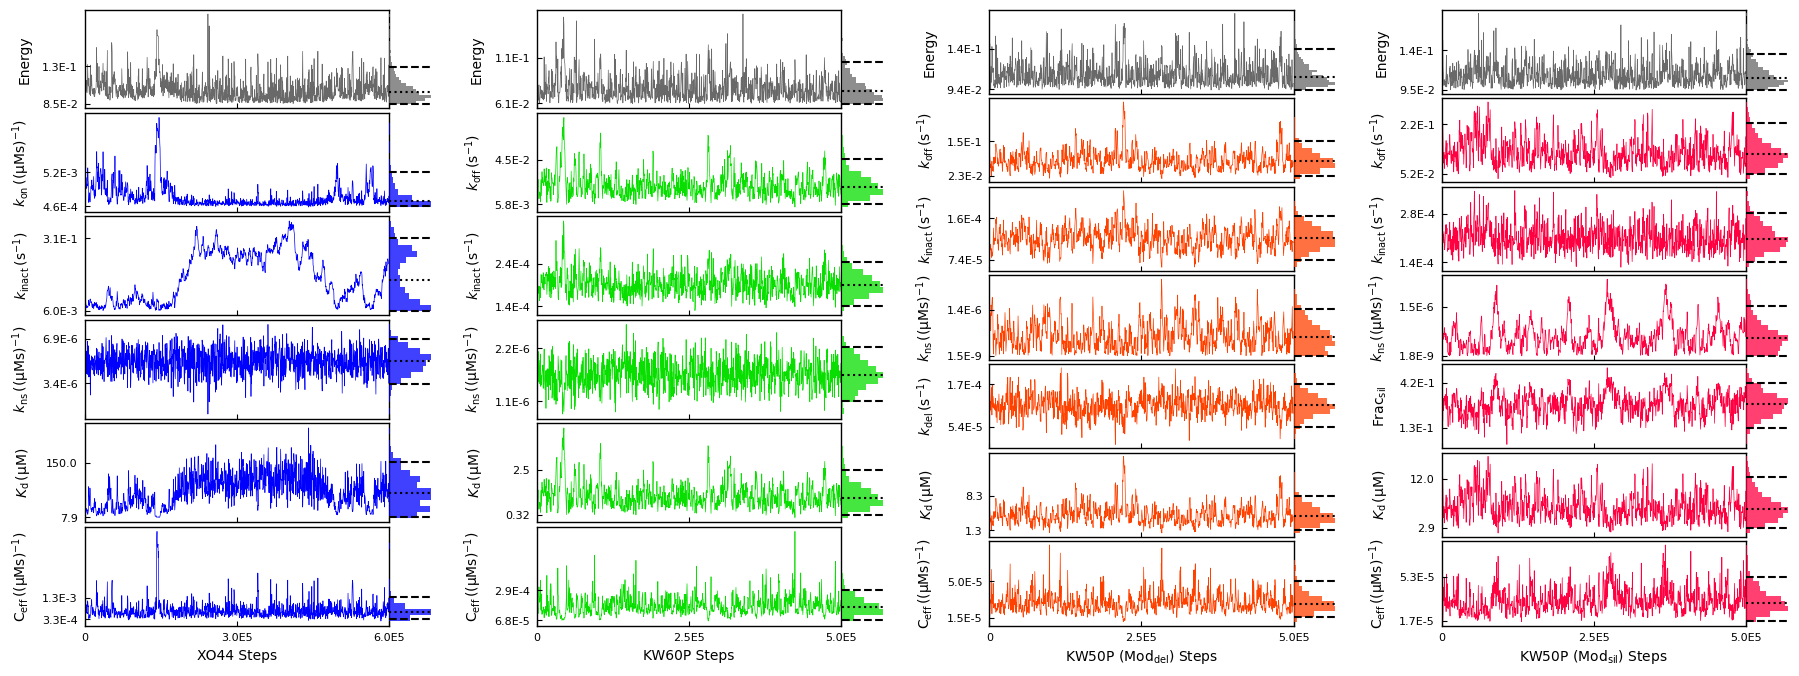

In [25]:

# Plot time evolution of the "energy" and parameters

# Variables for plot styling
label_fs = 10
label_x_offset = -0.175
lw = 0.5
plot_step = 1

fig = plt.figure(figsize=(22, 8))
outer_grid = gridspec.GridSpec(1, 4, wspace=0.3, hspace=0.1, figure=fig)

save_keys = [key for key in output_dict.keys() 
               if (not save_key_blacklist or key not in save_key_blacklist)
               and (not save_key_whitelist or key in save_key_whitelist)]
num_ligands = len(save_keys)

# Configure scientific notation formatter for all axes
formatter = CustomSciFormatter(force_sci=True, sig_figs=2)
formatter_kd = CustomSciFormatter(low=-np.inf,high=4, sig_figs=2)

for idx, save_key in enumerate(save_keys):
    save_data = output_dict[save_key]
    lig_name = save_data["lig_name"]

    print(f"\n{'='*80}\n"
          f"{save_key}\n")
    mc_dict = save_data["mc"]
    params = mc_dict["params"]
    param_names = list(params.keys())
    params_to_vary = mc_dict["params_to_vary"]
    samples_all = mc_dict["result"]
    energy_all = mc_dict["energy"]
    burn = mc_dict["burn"]
    thin = mc_dict["thin"]

    samples = samples_all[burn::thin]
    energy = energy_all[burn::thin]
    steps_x = np.arange(len(energy_all))[burn::thin]

    max_energy = np.percentile(energy, energy_percent_thresh)
    filtered_indices = energy <= max_energy
    samples = samples[filtered_indices]
    energy = energy[filtered_indices]

    num_params = len(params_to_vary)
    
    total_rows = num_params + 3 # params + energy + Kd + Ceff
    

    # Determine subplot position in the main grid
    row = idx // 2
    col = idx % 2
    ligand_grid = gridspec.GridSpecFromSubplotSpec(total_rows, 2, 
                                                  subplot_spec=outer_grid[idx],
                                                  width_ratios=[7, 1], 
                                                  wspace=0.003, 
                                                  hspace=0.05)

    def add_plot_with_histogram(grid_pos, data, ylabel, formatter, lw, color, hdi_frac, label_fs, label_x_offset, hist_bins):
        # Plot line
        ax_plot = fig.add_subplot(ligand_grid[grid_pos, 0])
        ax_plot.plot(steps_x[::plot_step], data[::plot_step], lw=lw, c=color)
        ax_plot.set_ylabel(ylabel, fontsize=label_fs)
        ax_plot.yaxis.set_label_coords(label_x_offset, 0.5)
        ax_plot.set_xlim(0, len(energy_all))
        ax_plot.xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
        ax_plot.yaxis.set_major_formatter(formatter)

        lower_bound, upper_bound = hdi(data, hdi_prob=hdi_frac)
        ax_plot.set_yticks([round_sig(lower_bound, formatter.sig_figs, autoformat=False),
                            round_sig(upper_bound, formatter.sig_figs, autoformat=False)])

        if grid_pos != total_rows - 1:
            ax_plot.set_xticklabels([])

        # Plot histogram
        median_val = np.median(data)
        ax_hist = fig.add_subplot(ligand_grid[grid_pos, 1])
        ax_hist.hist(data, bins=hist_bins, orientation='horizontal', color=color, alpha=0.75)
        ax_hist.axhline(median_val, c="black", ls=":", lw=1.5)
        ax_hist.axhline(lower_bound, c="black", ls="--", lw=1.5)
        ax_hist.axhline(upper_bound, c="black", ls="--", lw=1.5)
        ax_hist.axis('off')

    # Plot energy
    add_plot_with_histogram(0, energy, "Energy", formatter, lw, "dimgrey", hdi_frac, label_fs, label_x_offset, 30)

    # Plot each param value
    plot_idx = 1
    for param_name, param_data in params.items():
        if param_name not in params_to_vary: continue
        param_samples = samples[:, list(params.keys()).index(param_name)]
        add_plot_with_histogram(plot_idx, param_samples, label_dict[param_name], formatter, lw, color_dict[save_key], hdi_frac, label_fs, label_x_offset, 15)
        plot_idx += 1

    # Plot Kd
    Kd_arr = samples[:, param_names.index("koff")] / samples[:, param_names.index("kon")]
    add_plot_with_histogram(plot_idx, Kd_arr, label_dict["Kd"], formatter_kd, lw, color_dict[save_key], hdi_frac, label_fs, label_x_offset, 15)
    plot_idx += 1

    # Plot Ceff
    KI_arr = (samples[:, param_names.index("koff")] + samples[:, param_names.index("kinact")]) / samples[:, param_names.index("kon")]
    Ceff_arr = samples[:, param_names.index("kinact")] / KI_arr
    add_plot_with_histogram(plot_idx, Ceff_arr, label_dict["Ceff"], formatter, lw, color_dict[save_key], hdi_frac, label_fs, label_x_offset, 15)
    ax_ceff = fig.get_axes()[-2]
    ax_ceff.set_xlabel(f"{label_dict[save_key]} Steps", fontsize=label_fs)
    ax_ceff.xaxis.set_major_formatter(formatter)
    
# broad ax formatting
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=label_fs-2, direction='in', which='both', pad=5)
    ax.get_xaxis().get_offset_text().set_visible(False)
    ax.get_yaxis().get_offset_text().set_visible(False)
    for spine in ax.spines.values():
        spine.set_zorder(1e6)
        spine.set_linewidth(1)

# fig.savefig(f"mmc_steps.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()
clear_fig(fig)

### Simulate and plot samples

The kinetic simulations that correspond to each sampled set of parameters are not saved during the MMC loop, so it must be calculated again.

This is in a separate cell from the plotting because it can take a while (minutes). 

#### Simulate

In [29]:
# Initialize x-ranges
xtr_sim, xdr_sim = calc_common_x_spans(output_dict, save_key_whitelist, save_key_blacklist)

# Initialize sample simulation dictionary
if 'sample_sim_dict' not in globals():
    sample_sim_dict = {}

for save_key,save_data in output_dict.items():
    if save_key_blacklist and save_key in save_key_blacklist:continue
    if save_key_whitelist and save_key not in save_key_whitelist:continue

    print(f"\n{'='*80}\n"
          f"{save_key}\n")

    sample_sim_dict[save_key] = []
    lig_name = save_data["lig_name"]
    tr_data = save_data["fit_trdr"]["tr_data"]
    dr_data = save_data["fit_trdr"]["dr_data"]
    y_data = save_data["fit_trdr"]["y_data"]
    fit_trdr = save_data["fit_trdr"]["result"]
    step = step_dict[lig_name]
    
    samples_all = save_data["mc"]["result"]
    energy_all = save_data["mc"]["energy"]
    burn = save_data["mc"]["burn"]
    thin = save_data["mc"]["thin"]

    samples = samples_all[burn::thin]
    energy = energy_all[burn::thin]

    max_energy = np.percentile(energy, energy_percent_thresh)
    filtered_indices = energy <= max_energy
    samples = samples[filtered_indices]
    energy = energy[filtered_indices]

    print(f"{len(samples)} samples after energy filtering.")
    mc_params = save_data["mc"]["params"]
    mc_param_names = list(mc_params.keys())

    # Calculate HDI for each parameter
    hdi_bounds_dict = {}
    for param_name in mc_param_names:
        param_samples = samples[:, mc_param_names.index(param_name)]
        hdi_bounds_dict[param_name] = hdi(param_samples, hdi_prob=hdi_frac)

    # Filter samples based on HDI
    hdi_filtered_samples = []
    for sample in samples:
        within_hdi = True
        for param_name in mc_param_names:
            lower_bound, upper_bound = hdi_bounds_dict[param_name]
            param_value = sample[mc_param_names.index(param_name)]
            if not (lower_bound <= param_value <= upper_bound):
                within_hdi = False
                break
        if within_hdi:
            hdi_filtered_samples.append(sample)

    print(f"{len(hdi_filtered_samples)} samples after HDI filtering."
          f"\nSimulating every {step}."
          f"\n => {int(np.ceil(len(hdi_filtered_samples)/step))} samples will be simulated.")

    stepped_samples = hdi_filtered_samples[::step]
    for sample in tqdm(stepped_samples, desc=f"Simulating {save_key} samples"):
        kon = sample[mc_param_names.index("kon")]
        koff = sample[mc_param_names.index("koff")]
        kinact = sample[mc_param_names.index("kinact")]
        kns = sample[mc_param_names.index("kns")]
        ns_coeff = sample[mc_param_names.index("ns_coeff")]
        kdel = sample[mc_param_names.index("kdel")]
        frac_sil = sample[mc_param_names.index("frac_sil")]
        ytr, _ = simulate_tr(xtr_sim,kon,koff,kinact,kns,ns_coeff=ns_coeff,
                          kdel=kdel,frac_sil=frac_sil,response_sp=response_sp)
        ydr, _ = simulate_dr(xdr_sim,kon,koff,kinact,kns,ns_coeff=ns_coeff,
                          kdel=kdel,frac_sil=frac_sil,response_sp=response_sp)
        sample_sim_dict[save_key].append((ytr,ydr))
           


XO44

1200 samples after energy filtering.
984 samples after HDI filtering.
Simulating every 10.
 => 99 samples will be simulated.


Simulating XO44 samples: 100%|██████████| 99/99 [00:12<00:00,  7.90it/s]



KW60P

1000 samples after energy filtering.
890 samples after HDI filtering.
Simulating every 10.
 => 89 samples will be simulated.


Simulating KW60P samples: 100%|██████████| 89/89 [00:08<00:00, 10.86it/s]



KW50P_del

1000 samples after energy filtering.
866 samples after HDI filtering.
Simulating every 10.
 => 87 samples will be simulated.


Simulating KW50P_del samples: 100%|██████████| 87/87 [00:08<00:00, 10.81it/s]



KW50P_sil

1000 samples after energy filtering.
848 samples after HDI filtering.
Simulating every 10.
 => 85 samples will be simulated.


Simulating KW50P_sil samples: 100%|██████████| 85/85 [00:07<00:00, 11.02it/s]


#### Plot


XO44


KW60P


KW50P_del


KW50P_sil



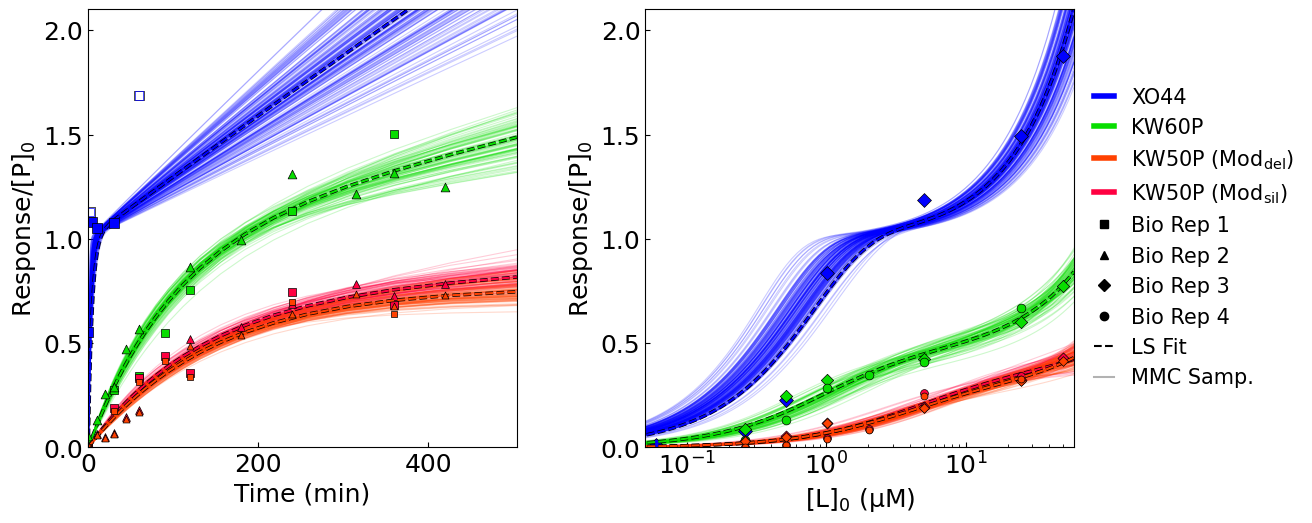

In [27]:

# Initialize figure
fig, axs = plt.subplots(1,2,figsize=(14, 6), gridspec_kw={'wspace': 0.3})
format_spines(fig)

id_set = set()
for save_key,save_data in output_dict.items():
    if save_key_blacklist and save_key in save_key_blacklist:continue
    if save_key_whitelist and save_key not in save_key_whitelist:continue

    print(f"\n{'='*80}\n"
          f"{save_key}\n")

    lig_name = save_data["lig_name"]
    fit_trdr = save_data["fit_trdr"]
    tr_data = save_data["fit_trdr"]["tr_data"]
    dr_data = save_data["fit_trdr"]["dr_data"]
    fit_result = save_data["fit_trdr"]["result"]
    sample_sims = sample_sim_dict[save_key]

    # Plot samples
    for ytr,ydr in sample_sims:
        axs[0].plot(xtr_sim/60, ytr, label=None, c=color_dict[save_key], ls='-', 
                    alpha=sample_alpha, zorder=zorder_dict[save_key], lw=sample_lw)
        axs[1].plot(xdr_sim, ydr, label=None, c=color_dict[save_key], ls='-', 
                    alpha=sample_alpha, zorder=zorder_dict[save_key], lw=sample_lw)

    # Sim and plot least-squares fit
    kon = fit_result.params["kon"].value
    koff = fit_result.params["koff"].value
    kinact = fit_result.params["kinact"].value
    kns = fit_result.params["kns"].value
    ns_coeff = fit_result.params["ns_coeff"].value
    kdel = fit_result.params["kdel"].value
    frac_sil = fit_result.params["frac_sil"].value
    ytr, _ = simulate_tr(xtr_sim, kon, koff, kinact, kns, ns_coeff=ns_coeff,
                      kdel=kdel, frac_sil=frac_sil, response_sp=response_sp)
    ydr, _ = simulate_dr(xdr_sim, kon, koff, kinact, kns, ns_coeff=ns_coeff,
                      kdel=kdel, frac_sil=frac_sil, response_sp=response_sp)
    line, = axs[0].plot(xtr_sim/60, ytr, label=None, c=color_dict[save_key], ls='--', 
                        alpha=1, zorder=zorder_dict[save_key]+11+1e5, dash_joinstyle="miter")
    line.set_path_effects([patheffects.withStroke(linewidth=dash_stroke, foreground='black')])
    line, = axs[1].plot(xdr_sim, ydr, label=None, c=color_dict[save_key], ls='--', 
                        alpha=1, zorder=zorder_dict[save_key]+11+1e5, dash_joinstyle="miter")
    line.set_path_effects([patheffects.withStroke(linewidth=dash_stroke, foreground='black')])
    
    # Plot experimental data
    base_scatter_size = 75
    scatter_size = base_scatter_size - 25*np.sqrt(zorder_dict[save_key]/1000)
    for exp_id, data_type, x_data_idx in fit_trdr["id_map"]:
        id_set.add(exp_id)
        y_data_scaled = fit_trdr["y_data_scaled"][exp_id]
        scalar_name = f"{data_type}_scalar{x_data_idx}"
        scalar_value = fit_trdr["result"].params[scalar_name].value
        if data_type == "tr":
            exp_data = exp_dict[lig_name]["time response"][exp_id]
            x_data = tr_data[x_data_idx][0]
            axs[0].scatter(x_data/60, y_data_scaled, label=None, c=color_dict[save_key], 
                           marker=shape_dict[exp_id], ls='None',alpha=1, ec="black", 
                           lw=points_lw, zorder=zorder_dict[save_key]+110+1e5,s=scatter_size)
            if "blacklisted" in exp_data:
                axs[0].scatter(exp_data["blacklisted"]["time"]/60, 
                               exp_data["blacklisted"]["norm response"] / scalar_value,
                               label=None, marker=shape_dict[exp_id], 
                               ls='None', fc="none",zorder=zorder_dict[save_key]+110+1e5,
                               ec="black", lw=points_lw,s=scatter_size)
                axs[0].scatter(exp_data["blacklisted"]["time"]/60, 
                               exp_data["blacklisted"]["norm response"] / scalar_value, 
                               label=None, marker=shape_dict[exp_id], 
                               ls='None', fc="none", zorder=zorder_dict[save_key]+110+1e5,
                               ec=color_dict[save_key], lw=points_lw,s=scatter_size*0.75)
        elif data_type == "dr":
            exp_data = exp_dict[lig_name]["dose response"][exp_id]
            x_data = dr_data[x_data_idx][0]
            axs[1].scatter(x_data, y_data_scaled, label=None, c=color_dict[save_key], 
                           marker=shape_dict[exp_id], ls='None',alpha=1, ec="black", 
                           lw=points_lw, zorder=zorder_dict[save_key]+110+1e5,s=scatter_size)
            if "blacklisted" in exp_data:
                axs[1].scatter(exp_data["blacklisted"]["concL0"], 
                               exp_data["blacklisted"]["norm response"] / scalar_value, 
                               label=None, marker=shape_dict[exp_id], 
                               ls='None', fc="none", zorder=zorder_dict[save_key]+110+1e5,
                               ec="black", lw=points_lw,s=scatter_size)
                axs[1].scatter(exp_data["blacklisted"]["concL0"], 
                               exp_data["blacklisted"]["norm response"] / scalar_value, 
                               label=None, marker=shape_dict[exp_id], 
                               ls='None', fc="none", zorder=zorder_dict[save_key]+110+1e5,
                               ec=color_dict[save_key], lw=points_lw,s=scatter_size*0.75)

axs[0].set_xlabel("Time (min)")
axs[0].set_ylabel("Response/[P]$_0$")

axs[1].set_xlabel("[L]$_0$ (μM)")
axs[1].set_ylabel("Response/[P]$_0$")
axs[1].set_xscale("log")

axs[0].set_xlim(0,xtr_sim[-1]/60)
axs[1].set_xlim(0.05,xdr_sim[-1])
if axs[0].get_ylim()[1] < 1:
    axs[0].set_ylim(0,1.1)
else:
    axs[0].set_ylim(0,2.1)
if axs[1].get_ylim()[1] < 1:
    axs[1].set_ylim(0,1.1)
else:
    axs[1].set_ylim(0,2.1)

# Make figure legend
for save_key,save_data in output_dict.items():
    if save_key_blacklist and save_key in save_key_blacklist:continue
    if save_key_whitelist and save_key not in save_key_whitelist:continue
    lig_name = save_data["lig_name"]
    axs[0].plot([],[],c=color_dict[save_key],label=label_dict[save_key],alpha=1,lw=4)
for exp_id in sorted(id_set):
    axs[0].plot([],[],label=label_dict[exp_id],c="black",marker=shape_dict[exp_id],ls='None')
axs[0].plot([],[],label="LS Fit",c="black",ls='--')
axs[0].plot([],[],label="MMC Samp.",c="black",ls='-',alpha=0.3)
handles, labels = axs[0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1, 0.5), 
                    frameon=False, fontsize="small",handlelength=1)
legend_width = legend.get_window_extent().width/fig.dpi
legend_width_fraction = legend_width/fig.get_figwidth() 
fig.subplots_adjust(right=1-legend_width_fraction*1.1,bottom=0.15)

# fig.savefig(f"mmc_lines.pdf",format="pdf",dpi=300, bbox_inches="tight")
plt.show()
clear_fig(fig)